In [ ]:
import sqlite3 as sql
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm


In [ ]:
# Helper Functions

def run_query(q):
    with sql.connect('chinook.db') as conn:
        return pd.read_sql(q, conn)

def run_command(c):
    with sql.connect('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(c)

def show_tables():
    q = "select name,type FROM sqlite_master where type in ('table','view');"
    return run_query(q)
    

In [48]:
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


In [49]:
albums_to_purchase = '''
WITH usa_tracks_sold AS
    (
    SELECT il.* FROM invoice_line il
    INNER JOIN invoice i on i.invoice_id = il.invoice_id
    INNER JOIN customer c on c.customer_id = i.customer_id
    WHERE c.country = "USA"
    )

SELECT
    g.name genre,
    count(uts.invoice_line_id) tracks_sold,
    cast(count(uts.invoice_line_id) AS FLOAT) / (
        SELECT COUNT(*) from usa_tracks_sold
    ) percentage_sold
FROM usa_tracks_sold uts
INNER JOIN track t on t.track_id = uts.track_id
INNER JOIN genre g on g.genre_id = t.genre_id
GROUP BY 1
ORDER BY 2 DESC
LIMIT 10;'''

run_query(albums_to_purchase)

,genre,tracks_sold,percentage_sold
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Latin,22,0.020932
7,Pop,22,0.020932
8,Hip Hop/Rap,20,0.019029
9,Jazz,14,0.013321


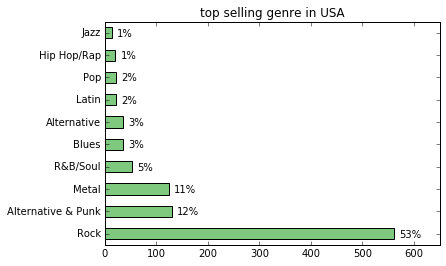

In [83]:
genre_sales_usa = run_query(albums_to_purchase)
genre_sales_usa.set_index('genre',drop= True, inplace = True)
genre_sales_usa['tracks_sold'].plot.barh(
                title = 'top selling genre in USA',
                xlim = (0,650),
                colormap = plt.cm.Accent
                )
plt.ylabel('')
for i, label in enumerate(list(genre_sales_usa.index)):
    score = genre_sales_usa.loc[label, 'tracks_sold']
    label = (genre_sales_usa.loc[label, 'percentage_sold'] * 100).astype(int).astype(str) + '%'
    plt.annotate(str(label),(score+10,i-0.15))
    
plt.show()

Based on the sales trend in USA we should but the following albums
Red Tone(Punk)
Slim Jim Bites (Blues)
Meteor and the Girls(Pop)
Also its worth noting the Rock is the highest selling genre in USA.

In [78]:
employee_performance = '''
WITH total_purchase AS
        (
        SELECT c.customer_id,c.support_rep_id,SUM(i.total) purchases
        FROM customer c
        INNER JOIN invoice i 
        ON c.customer_id = i.customer_id
        GROUP BY 1
        )

SELECT e.first_name||' '||e.last_name employee_name,
e.title title,
e.hire_date hire_date, 
SUM(tp.purchases) total_sale
FROM employee e
INNER JOIN total_purchase tp on tp.support_rep_id = e.employee_id
GROUP BY 1
ORDER BY 4 DESC;
'''
run_query(employee_performance)

,employee_name,title,hire_date,total_sale
0,Jane Peacock,Sales Support Agent,2017-04-01 00:00:00,1731.51
1,Margaret Park,Sales Support Agent,2017-05-03 00:00:00,1584.00
2,Steve Johnson,Sales Support Agent,2017-10-17 00:00:00,1393.92


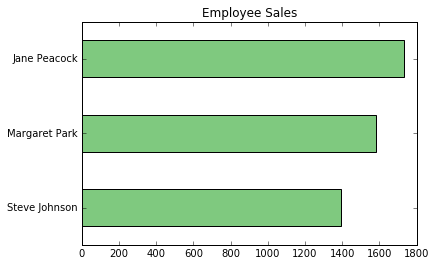

In [82]:
employee_sales = run_query(employee_performance)
employee_sales.set_index('employee_name',drop = True, inplace = True)
employee_sales.sort_values('total_sale', inplace = True)
employee_sales.plot.barh(
        title = 'Employee Sales',
        legend = False,
        colormap = plt.cm.Accent)
plt.ylabel('')
plt.show()

There is difference between Jane(top employee) and Steve(bottom employee) that roughly corresponds to their joining dates.

## Analyzing Sales by Country

In [107]:
sales_by_country = '''
WITH country_or_other AS
        (
        SELECT
        CASE
            WHEN (
                    SELECT count(*)
                    FROM customer
                    WHERE country = c.country
                ) = 1 THEN 'other'
                ELSE c.country
        END as country,
        c.customer_id,
        il.*
        FROM customer c 
        INNER JOIN invoice i on c.customer_id = i.customer_id
        INNER JOIN invoice_line il on i.invoice_id = il.invoice_id          
        )
SELECT
country,
customers,
total_sales,
average_order,
customer_lifetime_value
FROM 
    (
    SELECT
    country,
    count(distinct customer_id) customers,
    sum(unit_price) total_sales,
    (sum(unit_price)/count(distinct customer_id)) customer_lifetime_value,
    sum(unit_price)/count(distinct invoice_id) average_order,
    CASE
        WHEN country = 'other' THEN 1
        ELSE 0
    END as sort
    FROM country_or_other
    Group by country
    Order by sort ASC, total_sales DESC
    );
'''

run_query(sales_by_country)

,country,customers,total_sales,average_order,customer_lifetime_value
0,USA,13,1040.49,7.942672,80.037692
1,Canada,8,535.59,7.047237,66.948750
2,Brazil,5,427.68,7.011148,85.536000
3,France,5,389.07,7.781400,77.814000
4,Germany,4,334.62,8.161463,83.655000
5,Czech Republic,2,273.24,9.108000,136.620000
6,United Kingdom,3,245.52,8.768571,81.840000
7,Portugal,2,185.13,6.383793,92.565000
8,India,2,183.15,8.721429,91.575000
9,other,15,1094.94,7.448571,72.996000


## Data Visualizations

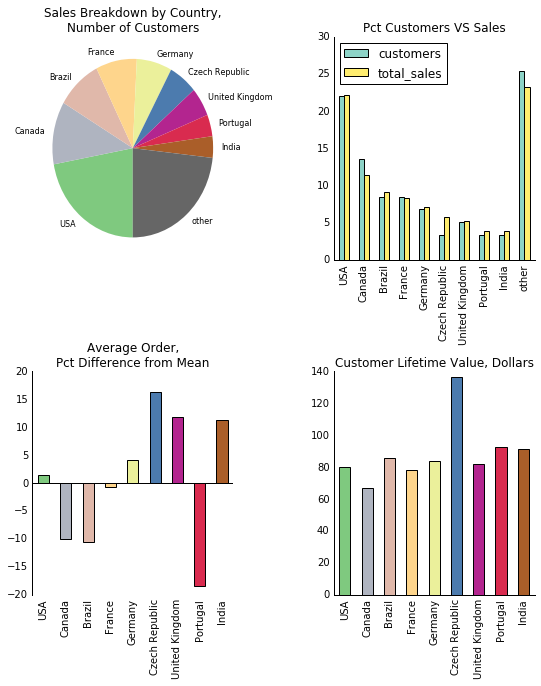

In [186]:
country_metrics = run_query(sales_by_country)
country_metrics.set_index('country',drop=True, inplace=True)
colors = [plt.cm.Accent(i) for i in np.linspace(0, 1, country_metrics.shape[0])]

fig,axes = plt.subplots(nrows=2, ncols=2,figsize =(9,10))
ax1,ax2,ax3,ax4 = axes.flatten()
fig.subplots_adjust(hspace = .5, wspace = .5)

#top left
sales_breakdown = country_metrics['total_sales'].copy().rename('')
sales_breakdown.plot.pie(
    ax = ax1,
    title='Sales Breakdown by Country,\nNumber of Customers',
    startangle = -90,
    counterclock = False,
    colormap = plt.cm.Accent,
    fontsize=8,
    wedgeprops={'linewidth':0})

#top right
cvd_cols = ["customers","total_sales"]
custs_vs_dollars = country_metrics[cvd_cols].copy()
custs_vs_dollars.index.name = ''
for c in cvd_cols:
    custs_vs_dollars[c] /= custs_vs_dollars[c].sum()/100
custs_vs_dollars.plot.bar(
        ax = ax2,
        colormap = plt.cm.Set3,
        title = 'Pct Customers VS Sales')
ax2.tick_params(top = 'off',bottom = 'off', left='off', right = 'off')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

#bottom Left
avg_order = country_metrics['average_order'].copy()
avg_order.index.name = ''
difference_from_avg = avg_order*100/avg_order.mean() -100
difference_from_avg.drop('other',inplace = True)
difference_from_avg.plot.bar(
    ax = ax3,
    color = colors,
    title = 'Average Order,\nPct Difference from Mean')
ax3.axhline(0,color = 'k')
ax3.tick_params(top = 'off', bottom = 'off', left = 'off', right = 'off')
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['bottom'].set_visible(False)

#Bottom Right
ltv = country_metrics["customer_lifetime_value"].copy()
ltv.index.name = ''
ltv.drop("other",inplace=True)
ltv.plot.bar(
    ax=ax4,
    color=colors,
    title="Customer Lifetime Value, Dollars"
)
ax4.tick_params(top="off", right="off", left="off", bottom="off")
ax4.spines["top"].set_visible(False)
ax4.spines["right"].set_visible(False)

plt.show()

Visualizations show that the following countries may have opportunities:
Czech Republic
United Kingdom
India
But since the data represents a small sample, it would be better to run a small campaigns and analyze the trends with new customers to make sure that these trends hold true with new customers.



## Album VS Tracks

In [198]:
album_vs_tracks = '''
With invoice_first_track AS
            (
            SELECT il.invoice_id,
            il.track_id first_track_id
            from invoice_line il
            Group By 1
            )
SELECT album_purchase,
count(invoice_id) number_of_invoices,
CAST(count(invoice_id) as Float)/(select count(*) from invoice) Percent
FROM
    (
    SELECT ifs.*,
    CASE
        WHEN
            (
            SELECT t.track_id from track t
            WHERE t.album_id = (
                                SELECT t2.album_id from track t2
                                WHERE t2.track_id = ifs.first_track_id
                                )
            EXCEPT
            SELECT il2.track_id from invoice_line il2
            WHERE il2.invoice_id = ifs.invoice_id 
             )IS NULL    
        AND  
            (
            SELECT il2.track_id from invoice_line il2
            WHERE il2.invoice_id = ifs.invoice_id 
            EXCEPT
            SELECT t.track_id from track t
            WHERE t.album_id = (
                                SELECT t2.album_id from track t2
                                WHERE t2.track_id = ifs.first_track_id
                                ) 
            ) IS NULL
        THEN "yes"
        ELSE "no"
    END AS "album_purchase"
    FROM invoice_first_track ifs
    )
    Group By 1

'''

run_query(album_vs_tracks)

,album_purchase,number_of_invoices,Percent
0,no,500,0.814332
1,yes,114,0.185668


18% of the sales are album purchase. If chinook decide to purhcase only the tracks. they might loose approx 1/5th of the revenue